# Overfitting and underfitting


**Credits to: Code and text adapted from [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) Chapter 3, Section 6**


**The fundamental issue in machine learning is the tension between optimization and generalization. "Optimization" refers to the process of 
adjusting a model to get the best performance possible on the training data (the "learning" in "machine learning"), while "generalization" 
refers to how well the trained model would perform on data it has never seen before. The goal of the game is to get good generalization, of 
course, but you do not control generalization; you can only adjust the model based on its training data**.

**At the beginning of training, optimization and generalization are correlated: the lower your loss on training data, the lower your loss on 
test data. While this is happening, your model is said to be _under-fit_: there is still progress to be made; the network hasn't yet 
modeled all relevant patterns in the training data. But after a certain number of iterations on the training data, generalization stops 
improving, validation metrics stall then start degrading: the model is then starting to over-fit, i.e. is it starting to learn patterns 
that are specific to the training data but that are misleading or irrelevant when it comes to new data**.

To prevent a model from learning misleading or irrelevant patterns found in the training data, **_the best solution is of course to get 
more training data_**. A model trained on more data will naturally generalize better. When that is no longer possible, **the next best solution 
is to modulate the quantity of information that your model is allowed to store, or to add constraints on what information it is allowed to 
store**. If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most 
**prominent** patterns, which have a better chance of generalizing well.

The processing of fighting overfitting in this way is called **_regularization_**. Let's review some of the most common regularization 
techniques, and let's apply them in practice to improve our movie classification model from  the previous chapter.

## Set up:

Dependencies:

In [1]:
! pip install torchinfo

In [2]:
import numpy as np
import keras
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from keras.datasets import imdb
from torch.utils.data import Dataset, DataLoader
from pprint import pprint
from torchinfo import summary

Seed:

In [3]:
seed = 7777
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Device:

In [4]:
# set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data

Note: in this notebook we will be using the IMDB test set as our validation set. It doesn't matter in this context.

### Download dataset

In [5]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [7]:
# One-hot encoding of document. Each number indicate a word presents (1) or does not present in the doc (0)
print(train_data[0][:5])
print(x_train[0][:50])  # dictionary

[1, 14, 22, 16, 43]
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0.]


Define dataset class:

In [13]:
class IMDB_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).float()
        self.y = torch.Tensor(y).float()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]

# dataset
train_data = IMDB_dataset(x_train, y_train)
test_data = IMDB_dataset(x_test, y_test)

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is 
determined by the number of layers and the number of units per layer). In deep learning, **the number of learnable parameters in a model is 
often referred to as the model's "capacity"**. Intuitively, **a model with more parameters will have more "memorization capacity"** and therefore 
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any 
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the 
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying 
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge 
is generalization, not fitting.

On the other hand, if the network has **limited memorization resources**, it will not be able to learn this mapping as easily, and thus, in 
order to minimize its loss, it will have to resort to learning **compressed representations that have predictive power** regarding the targets -- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using **models that have 
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources**. There is a compromise to be 
found between **"too much capacity"** and **"not enough capacity"**.

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You 
will have to evaluate an array of different architectures (**on your validation set, not on your test set**, of course) in order to find the 
right model size for your data. The general workflow to find an appropriate model size is to **start with relatively few layers and 
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the 
validation loss**.

Let's try this on our movie review classification network.

Define model class

In [9]:
# simple_model
class simple_model(nn.Module):
    def __init__(self, hidden_units):
        # initialize parent class
        super(simple_model, self).__init__()
        # define layers
        self.classifier = nn.Sequential(  # define a subcomponent of neural network or another to define model
            nn.Linear(in_features=10000, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=1)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [10]:
model_visual = simple_model(16)
summary(model_visual, (10, 10000))

Layer (type:depth-idx)                   Output Shape              Param #
simple_model                             --                        --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 16]                  160,016
│    └─ReLU: 2-2                         [10, 16]                  --
│    └─Linear: 2-3                       [10, 16]                  272
│    └─ReLU: 2-4                         [10, 16]                  --
│    └─Linear: 2-5                       [10, 1]                   17
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.40
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 1.04

Train model function:

In [36]:
def train_model(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1) # (num_batch, 1) -> (num_batch,)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item()
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.3f} train_acc:{train_acc:.3f}, validation loss:{val_loss:.3f} validation acc:{val_acc:.3f}")
    
    return history

**BCEWithLogistsLoss()**:  
This loss function is just a combination of sigmoid layer and binary cross entropy layer. The combination enable the function to achieve a higher numerical stability(See: [this](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/)). When we use it, we don't need to add a sigmoid layer in our model.

A short example:

In [15]:
target = torch.ones([64, 1], dtype=torch.float32) 
output = torch.full([64, 1], 1.5)

print(target[:5])
print(output[:5])

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[1.5000],
        [1.5000],
        [1.5000],
        [1.5000],
        [1.5000]])


In [16]:
# apply
criterion = nn.BCEWithLogitsLoss()  # defeault reduction is mean
print(criterion(output, target))

tensor(0.2014)


It equals to sigmoid layer following Binary Cross Entropy:

In [17]:
sigmoid_func = nn.Sigmoid()
BCE_func = nn.BCELoss()
print(BCE_func(sigmoid_func(output), target))

tensor(0.2014)


Train model:

In [57]:
original = simple_model(16)
original_hist = train_model(original, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.519 train_acc:0.834, validation loss:0.399 validation acc:0.873
Epoch:2 / 20, train loss:0.312 train_acc:0.894, validation loss:0.302 validation acc:0.886
Epoch:3 / 20, train loss:0.237 train_acc:0.915, validation loss:0.277 validation acc:0.892
Epoch:4 / 20, train loss:0.201 train_acc:0.928, validation loss:0.274 validation acc:0.892
Epoch:5 / 20, train loss:0.178 train_acc:0.937, validation loss:0.278 validation acc:0.891
Epoch:6 / 20, train loss:0.161 train_acc:0.945, validation loss:0.286 validation acc:0.888
Epoch:7 / 20, train loss:0.146 train_acc:0.950, validation loss:0.298 validation acc:0.885
Epoch:8 / 20, train loss:0.134 train_acc:0.955, validation loss:0.312 validation acc:0.881
Epoch:9 / 20, train loss:0.124 train_acc:0.959, validation loss:0.328 validation acc:0.879
Epoch:10 / 20, train loss:0.115 train_acc:0.963, validation loss:0.345 validation acc:0.876
Epoch:11 / 20, train loss:0.106 train_acc:0.966, validation loss:0.363 val

In [58]:
smaller = simple_model(4)
smaller_hist = train_model(smaller, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.589 train_acc:0.771, validation loss:0.520 validation acc:0.849
Epoch:2 / 20, train loss:0.447 train_acc:0.875, validation loss:0.412 validation acc:0.872
Epoch:3 / 20, train loss:0.349 train_acc:0.895, validation loss:0.344 validation acc:0.883
Epoch:4 / 20, train loss:0.286 train_acc:0.907, validation loss:0.306 validation acc:0.889
Epoch:5 / 20, train loss:0.247 train_acc:0.916, validation loss:0.286 validation acc:0.890
Epoch:6 / 20, train loss:0.221 train_acc:0.923, validation loss:0.276 validation acc:0.892
Epoch:7 / 20, train loss:0.202 train_acc:0.930, validation loss:0.272 validation acc:0.892
Epoch:8 / 20, train loss:0.188 train_acc:0.935, validation loss:0.271 validation acc:0.892
Epoch:9 / 20, train loss:0.176 train_acc:0.940, validation loss:0.273 validation acc:0.891
Epoch:10 / 20, train loss:0.166 train_acc:0.944, validation loss:0.275 validation acc:0.890
Epoch:11 / 20, train loss:0.157 train_acc:0.947, validation loss:0.279 val


Here's a comparison of the validation losses of the original network and the smaller network(remember: a lower validation loss signals a better model).

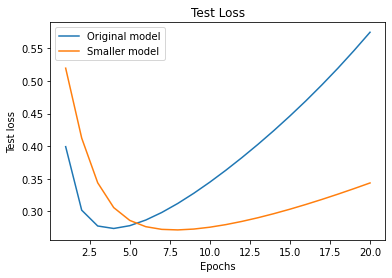

In [59]:
plt.plot(range(1, 21), original_hist['test_loss'], label='Original model')
plt.plot(range(1, 21), smaller_hist['test_loss'], label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()
plt.title("Test Loss")
plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 10 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [60]:
bigger = simple_model(512)
bigger_hist = train_model(bigger, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.314 train_acc:0.873, validation loss:0.283 validation acc:0.887
Epoch:2 / 20, train loss:0.189 train_acc:0.930, validation loss:0.312 validation acc:0.878
Epoch:3 / 20, train loss:0.132 train_acc:0.954, validation loss:0.366 validation acc:0.868
Epoch:4 / 20, train loss:0.077 train_acc:0.975, validation loss:0.439 validation acc:0.864
Epoch:5 / 20, train loss:0.032 train_acc:0.991, validation loss:0.593 validation acc:0.860
Epoch:6 / 20, train loss:0.011 train_acc:0.997, validation loss:0.823 validation acc:0.862
Epoch:7 / 20, train loss:0.004 train_acc:0.999, validation loss:0.946 validation acc:0.860
Epoch:8 / 20, train loss:0.003 train_acc:0.999, validation loss:1.045 validation acc:0.858
Epoch:9 / 20, train loss:0.002 train_acc:1.000, validation loss:1.162 validation acc:0.859
Epoch:10 / 20, train loss:0.002 train_acc:1.000, validation loss:1.263 validation acc:0.860
Epoch:11 / 20, train loss:0.000 train_acc:1.000, validation loss:1.523 val

Here's how the bigger network fares compared to the reference one.

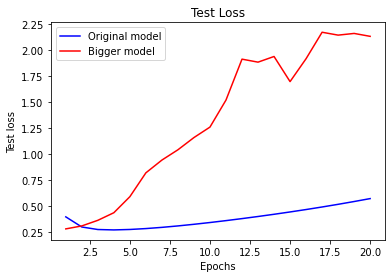

In [61]:
plt.plot(range(1, 21), original_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), bigger_hist['test_loss'], 'r-', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()
plt.title("Test Loss")

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

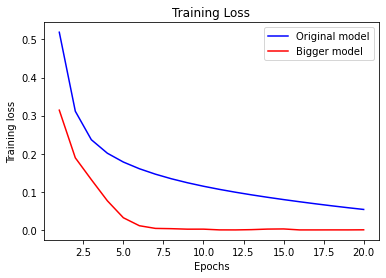

In [62]:
plt.plot(range(1, 21), original_hist['train_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), bigger_hist['train_loss'], 'r-', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()
plt.title("Training Loss")

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the 
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some 
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and 
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer 
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity 
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called 
`weight regularization` or `norm regularization`, and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This 
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the 
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called 
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different 
name confuse you: weight decay is mathematically the exact same as L2 regularization.

To apply L2 regularization in Pytorch, we just need a minor modification in train function:

- L2: Use `weight_decay` parameter in optimizer, i.e.,  `torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)`

- L1: There is no torch implementation for L1 analogous to Keras. However, the implementation of L1 is very straightforward, e.g.:


# Implementation of L1 Regularizer

```
loss = loss_fn(outputs, labels) # loss
l1_lambda = 0.001 # L1 coefficient
l1_norm = sum(p.abs().sum() for p in model.parameters())  # add up L1 norma of parameters

loss = loss + l1_lambda * l1_norm  # add to the loss
```


In [63]:
# define model
l2_model = simple_model(16)

In [64]:
def train_model_l2(model, train_dataset, test_dataset, device, lr=0.0001, epochs=20, batch_size=32, l2=0.01):
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2) # weight decay == l2

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        for x, y in train_loader:
            # move data to device
            x = x.to(device)
            y = y.to(device)
            # forward
            outputs = model(x).view(-1)
            pred = torch.round(torch.sigmoid(outputs))
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item() 
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in test_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                outputs = model(x).view(-1)
                pred = torch.round(torch.sigmoid(outputs))
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item()  
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader)).item()
        val_acc = test_acc/len(test_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(val_loss)
        history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.3f} train_acc:{train_acc:.3f}, validation loss:{val_loss:.3f} validation acc:{val_acc:.3f}")
    
    return history

Here's the impact of our L2 regularization penalty:

In [65]:
l2_model_hist = train_model_l2(l2_model, train_data, test_data, device, l2=0.01)

Training Start
Epoch:1 / 20, train loss:0.604 train_acc:0.712, validation loss:0.469 validation acc:0.858
Epoch:2 / 20, train loss:0.373 train_acc:0.876, validation loss:0.336 validation acc:0.877
Epoch:3 / 20, train loss:0.292 train_acc:0.893, validation loss:0.305 validation acc:0.882
Epoch:4 / 20, train loss:0.261 train_acc:0.904, validation loss:0.293 validation acc:0.885
Epoch:5 / 20, train loss:0.243 train_acc:0.911, validation loss:0.289 validation acc:0.884
Epoch:6 / 20, train loss:0.230 train_acc:0.917, validation loss:0.286 validation acc:0.885
Epoch:7 / 20, train loss:0.220 train_acc:0.922, validation loss:0.285 validation acc:0.885
Epoch:8 / 20, train loss:0.212 train_acc:0.926, validation loss:0.285 validation acc:0.885
Epoch:9 / 20, train loss:0.205 train_acc:0.929, validation loss:0.286 validation acc:0.884
Epoch:10 / 20, train loss:0.199 train_acc:0.932, validation loss:0.286 validation acc:0.883
Epoch:11 / 20, train loss:0.193 train_acc:0.934, validation loss:0.287 val

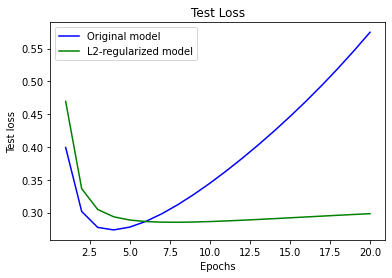

In [66]:
plt.plot(range(1, 21), original_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), l2_model_hist['test_loss'], 'g-', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()
plt.title("Test Loss")

plt.show()



As you can see, the model with L2 regularization has become much more resistant to overfitting than the reference model, 
even though both models have the same number of parameters.

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his 
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of 
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a 
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5, 
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test 
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to 
balance for the fact that more units are active than at training time.


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among 
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked 
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation 
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each 
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what 
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present. 

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [67]:
# simple_model
class dropout_model(nn.Module):
    def __init__(self, hidden_units, dropout_ratio = 0.5):
        # initialize parent class
        super(dropout_model, self).__init__()
        # define layers
        self.classifier = nn.Sequential(  # define a subcomponent of neural network or another to define model
            nn.Linear(in_features=10000, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            nn.Linear(in_features=hidden_units, out_features=1)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [ ]:
model_visual = dropout_model(16)
summary(model_visual, (10, 10_000))

Layer (type:depth-idx)                   Output Shape              Param #
dropout_model                            --                        --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 16]                  160,016
│    └─ReLU: 2-2                         [10, 16]                  --
│    └─Dropout: 2-3                      [10, 16]                  --
│    └─Linear: 2-4                       [10, 16]                  272
│    └─ReLU: 2-5                         [10, 16]                  --
│    └─Dropout: 2-6                      [10, 16]                  --
│    └─Linear: 2-7                       [10, 1]                   17
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.40
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 1.04

In [34]:
original2 = simple_model(16)
original2_hist = train_model(original2, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.525 train_acc:0.841, validation loss:0.40033 validation acc:0.873
Epoch:2 / 20, train loss:0.312 train_acc:0.897, validation loss:0.30014 validation acc:0.888
Epoch:3 / 20, train loss:0.237 train_acc:0.915, validation loss:0.27590 validation acc:0.891
Epoch:4 / 20, train loss:0.203 train_acc:0.928, validation loss:0.27171 validation acc:0.892
Epoch:5 / 20, train loss:0.180 train_acc:0.937, validation loss:0.27548 validation acc:0.892
Epoch:6 / 20, train loss:0.162 train_acc:0.943, validation loss:0.28336 validation acc:0.889
Epoch:7 / 20, train loss:0.148 train_acc:0.949, validation loss:0.29406 validation acc:0.886
Epoch:8 / 20, train loss:0.136 train_acc:0.955, validation loss:0.30681 validation acc:0.883
Epoch:9 / 20, train loss:0.125 train_acc:0.958, validation loss:0.32133 validation acc:0.880
Epoch:10 / 20, train loss:0.116 train_acc:0.962, validation loss:0.33719 validation acc:0.877
Epoch:11 / 20, train loss:0.107 train_acc:0.966, valid

In [68]:
dropout = dropout_model(16, 0.5)
dropout_hist = train_model(dropout, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.651 train_acc:0.663, validation loss:0.583 validation acc:0.845
Epoch:2 / 20, train loss:0.541 train_acc:0.791, validation loss:0.452 validation acc:0.870
Epoch:3 / 20, train loss:0.443 train_acc:0.844, validation loss:0.372 validation acc:0.881
Epoch:4 / 20, train loss:0.374 train_acc:0.873, validation loss:0.323 validation acc:0.887
Epoch:5 / 20, train loss:0.331 train_acc:0.890, validation loss:0.297 validation acc:0.890
Epoch:6 / 20, train loss:0.299 train_acc:0.903, validation loss:0.287 validation acc:0.891
Epoch:7 / 20, train loss:0.275 train_acc:0.910, validation loss:0.280 validation acc:0.891
Epoch:8 / 20, train loss:0.252 train_acc:0.918, validation loss:0.283 validation acc:0.890
Epoch:9 / 20, train loss:0.236 train_acc:0.924, validation loss:0.284 validation acc:0.890
Epoch:10 / 20, train loss:0.223 train_acc:0.930, validation loss:0.292 validation acc:0.890
Epoch:11 / 20, train loss:0.210 train_acc:0.933, validation loss:0.298 val

Let's plot the results:

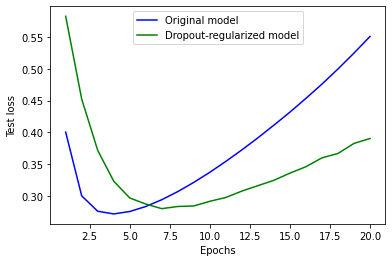

In [69]:
plt.plot(range(1, 21), original2_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), dropout_hist['test_loss'], 'g-', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()

plt.show()

## Batch Normalization

In [70]:
# simple_model
class batchnorm_model(nn.Module):
    def __init__(self, hidden_units, dropout_ratio = 0.5):
        # initialize parent class
        super(batchnorm_model, self).__init__()
        # define layers
        self.classifier = nn.Sequential(  # define a subcomponent of neural network or another to define model
            # nn.Dropout(dropout_ratio),
            nn.Linear(in_features=10000, out_features=hidden_units),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
                    
            nn.Linear(in_features=hidden_units, out_features=hidden_units),            
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),

            nn.Dropout(dropout_ratio),
            
            nn.Linear(in_features=hidden_units, out_features=1)
        )
    
    def forward(self, x):
        return self.classifier(x)

In [71]:
model_visual = batchnorm_model(16, dropout_ratio = 0.5)
summary(model_visual, (10, 10_000))

Layer (type:depth-idx)                   Output Shape              Param #
batchnorm_model                          --                        --
├─Sequential: 1-1                        [10, 1]                   --
│    └─Linear: 2-1                       [10, 16]                  160,016
│    └─ReLU: 2-2                         [10, 16]                  --
│    └─BatchNorm1d: 2-3                  [10, 16]                  32
│    └─Linear: 2-4                       [10, 16]                  272
│    └─ReLU: 2-5                         [10, 16]                  --
│    └─BatchNorm1d: 2-6                  [10, 16]                  32
│    └─Dropout: 2-7                      [10, 16]                  --
│    └─Linear: 2-8                       [10, 1]                   17
Total params: 160,369
Trainable params: 160,369
Non-trainable params: 0
Total mult-adds (M): 1.60
Input size (MB): 0.40
Forward/backward pass size (MB): 0.01
Params size (MB): 0.64
Estimated Total Size (MB): 1.05

In [72]:
batch = batchnorm_model(16, dropout_ratio = 0.5)
batch_hist = train_model(batch, train_data, test_data, device)

Training Start
Epoch:1 / 20, train loss:0.465 train_acc:0.786, validation loss:0.342 validation acc:0.870
Epoch:2 / 20, train loss:0.296 train_acc:0.889, validation loss:0.299 validation acc:0.880
Epoch:3 / 20, train loss:0.221 train_acc:0.924, validation loss:0.304 validation acc:0.873
Epoch:4 / 20, train loss:0.164 train_acc:0.948, validation loss:0.328 validation acc:0.866
Epoch:5 / 20, train loss:0.123 train_acc:0.965, validation loss:0.360 validation acc:0.860
Epoch:6 / 20, train loss:0.089 train_acc:0.976, validation loss:0.404 validation acc:0.854
Epoch:7 / 20, train loss:0.065 train_acc:0.985, validation loss:0.451 validation acc:0.848
Epoch:8 / 20, train loss:0.051 train_acc:0.988, validation loss:0.488 validation acc:0.848
Epoch:9 / 20, train loss:0.038 train_acc:0.991, validation loss:0.542 validation acc:0.846
Epoch:10 / 20, train loss:0.032 train_acc:0.992, validation loss:0.598 validation acc:0.843
Epoch:11 / 20, train loss:0.025 train_acc:0.994, validation loss:0.637 val

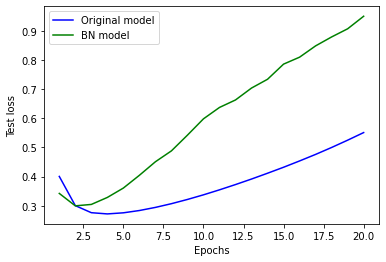

In [73]:
plt.plot(range(1, 21), original2_hist['test_loss'], 'b-', label='Original model')
plt.plot(range(1, 21), batch_hist['test_loss'], 'g-', label='BN model')
plt.xlabel('Epochs')
plt.ylabel('Test loss')
plt.legend()

plt.show()

The effect of batch normalization is not very significant in this case. However, it is considered as a useful technique used in training very deep neural network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.